In [ ]:
# ============================================
# Cell 1: Imports & Config
# ============================================
import os
from pathlib import Path
import random
import time

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# -----------------
# Device & Seeds
# -----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)


CROPPED_ROOT = Path("cropped")

# -----------------
# Hyperparameters
# -----------------
NUM_FRAMES   = 16     
BATCH_SIZE   = 1      
EPOCHS       = 10      
LR           = 1e-4
WEIGHT_DECAY = 1e-4


USE_TRANSFORMER_HEAD = False  # False = lighter ViT-FrameAvg model
print(f"NUM_FRAMES={NUM_FRAMES}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")


Using device: cpu
NUM_FRAMES=16, BATCH_SIZE=1, EPOCHS=10


In [3]:
# ============================================
# Cell 2: Dataset & Frame Loader
# ============================================

# Standard ViT image transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


def load_video_frames(folder: Path, num_frames: int):
    """
    Load up to num_frames frames from a video folder of cropped faces.
    - If > num_frames: sample uniformly.
    - If < num_frames: repeat frames to reach num_frames.
    Returns: tensor (T, 3, 224, 224).
    """
    frame_paths = sorted([p for p in folder.glob("*.jpg")])
    if len(frame_paths) == 0:
        # Fallback: black frames
        img = Image.new("RGB", (224, 224))
        frames = [transform(img) for _ in range(num_frames)]
        return torch.stack(frames, dim=0)

    if len(frame_paths) >= num_frames:
        idxs = np.linspace(0, len(frame_paths) - 1, num_frames).astype(int)
        selected = [frame_paths[i] for i in idxs]
    else:
        # Repeat frames cyclically
        reps = (num_frames + len(frame_paths) - 1) // len(frame_paths)
        extended = (frame_paths * reps)[:num_frames]
        selected = extended

    frames = []
    for fp in selected:
        try:
            img = Image.open(fp).convert("RGB")
        except:
            img = Image.new("RGB", (224, 224))
        frames.append(transform(img))

    return torch.stack(frames, dim=0)   # (T, 3, H, W)


class DeepFakeCroppedDataset(Dataset):
    """
    Dataset of cropped-face videos in folder-per-video layout.
    Assumes folder names contain "_real" or "_fake".
    """
    def __init__(self, video_folders, num_frames: int = 16):
        self.video_folders = video_folders
        self.num_frames = num_frames

        self.samples = []
        for vf in self.video_folders:
            name = vf.name.lower()
            if "_real" in name:
                label = 0.0
            elif "_fake" in name:
                label = 1.0
            else:
                print(f"Skipping {vf} (no _real/_fake in name)")
                continue
            self.samples.append((vf, label))

        print(f"Loaded {len(self.samples)} videos.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        folder, label = self.samples[idx]
        video_tensor = load_video_frames(folder, self.num_frames)  # (T, 3, 224, 224)
        return video_tensor, torch.tensor(label, dtype=torch.float32)


In [25]:

# ============================================
# Cell 3: Train / Val / Test Split
# ============================================

all_video_folders = sorted([p for p in CROPPED_ROOT.iterdir() if p.is_dir()])
print("Total video folders found:", len(all_video_folders))

# Separate real & fake by folder name
real_folders = [p for p in all_video_folders if "_real" in p.name.lower()]
fake_folders = [p for p in all_video_folders if "_fake" in p.name.lower()]

print("Found REAL folders:", len(real_folders))
print("Found FAKE folders:", len(fake_folders))

# Limit to 200 each (or fewer if not enough)
real_folders = real_folders[:200]
fake_folders = fake_folders[:200]

print("Using REAL:", len(real_folders))
print("Using FAKE:", len(fake_folders))

# Combine and shuffle
selected_folders = real_folders + fake_folders
random.shuffle(selected_folders)

N = len(selected_folders)
train_end = int(0.7 * N)   # 70%
val_end   = int(0.85 * N)  # 15% val, 15% test

train_folders = selected_folders[:train_end]
val_folders   = selected_folders[train_end:val_end]
test_folders  = selected_folders[val_end:]

print(f"Train videos: {len(train_folders)}")
print(f"Val videos:   {len(val_folders)}")
print(f"Test videos:  {len(test_folders)}")

# Build datasets
train_set = DeepFakeCroppedDataset(train_folders, num_frames=NUM_FRAMES)
val_set   = DeepFakeCroppedDataset(val_folders,   num_frames=NUM_FRAMES)
test_set  = DeepFakeCroppedDataset(test_folders,  num_frames=NUM_FRAMES)

# Dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)




Total video folders found: 1781
Found REAL folders: 1000
Found FAKE folders: 781
Using REAL: 200
Using FAKE: 200
Train videos: 280
Val videos:   60
Test videos:  60
Loaded 280 videos.
Loaded 60 videos.
Loaded 60 videos.


In [10]:
# ============================================
# Cell 4: Models
#   A) ViT_FrameAvg_Deepfake (light, recommended to start)
#   B) ViT_Transformer_Deepfake (optional, heavier)
# ============================================

class ViT_FrameAvg_Deepfake(nn.Module):
    """
    Lightweight baseline:
    - ViT-B/16 backbone (frozen)
    - Extract per-frame embedding
    - Average over time
    - Linear classifier
    """
    def __init__(self):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # output (B, 768)

        # Freeze ViT to save memory & avoid overfitting
        for p in self.vit.parameters():
            p.requires_grad = False

        self.fc = nn.Linear(768, 1)

    def forward(self, x):
        # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)        # (B*T, 3, 224, 224)

        feats = self.vit(x)               # (B*T, 768)
        feats = F.normalize(feats, dim=1)

        feats = feats.view(B, T, -1)      # (B, T, 768)
        video_feats = feats.mean(dim=1)   # (B, 768) frame-average

        logits = self.fc(video_feats).squeeze(-1)  # (B,)
        return logits


class ViT_Transformer_Deepfake(nn.Module):
    """
    Heavier model:
    - ViT-B/16 backbone (frozen)
    - Per-frame embeddings
    - Temporal Transformer encoder
    - Attention pooling over time
    - Linear classifier
    Use only if your kernel is stable with this.
    """
    def __init__(self, d_model=768, nhead=4, num_layers=1, dropout=0.3):
        super().__init__()
        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()

        # Freeze ViT
        for p in self.vit.parameters():
            p.requires_grad = False

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=2 * d_model,  # smaller FF
            dropout=dropout,
            batch_first=True,             # (B, T, D)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.attn = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (B, T, 3, 224, 224)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        feats = self.vit(x)               # (B*T, 768)
        feats = F.normalize(feats, dim=1)

        feats = feats.view(B, T, -1)      # (B, T, 768)

        enc = self.transformer(feats)     # (B, T, 768)

        attn_scores = self.attn(enc).squeeze(-1)   # (B, T)
        weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(enc * weights.unsqueeze(-1), dim=1)  # (B, 768)

        context = self.dropout(context)
        logits = self.fc(context).squeeze(-1)      # (B,)
        return logits


# -----------------
# Instantiate model
# -----------------
if USE_TRANSFORMER_HEAD:
    print("Using ViT + Temporal Transformer head.")
    model = ViT_Transformer_Deepfake().to(DEVICE)
else:
    print("Using lightweight ViT Frame-Average head.")
    model = ViT_FrameAvg_Deepfake().to(DEVICE)

print("Model parameters (trainable):",
      sum(p.numel() for p in model.parameters() if p.requires_grad))


Using lightweight ViT Frame-Average head.
Model parameters (trainable): 769


In [11]:
# ============================================
# Cell 5: Loss, Optimizer, Train/Val Functions
# ============================================

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

def train_one_epoch():
    model.train()
    total_loss = 0.0
    num_correct = 0
    num_samples = 0

    for videos, labels in tqdm(train_loader, desc="Train", leave=False):
        videos = videos.to(DEVICE)        # (B, T, 3, 224, 224)
        labels = labels.to(DEVICE)        # (B,)

        optimizer.zero_grad()

        logits = model(videos)            # (B,)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        total_loss += loss.item() * labels.size(0)
        num_correct += (preds == labels.long()).sum().item()
        num_samples += labels.size(0)

    return total_loss / num_samples, num_correct / num_samples


def validate():
    model.eval()
    total_loss = 0.0
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc="Val", leave=False):
            videos = videos.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(videos)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            total_loss += loss.item() * labels.size(0)
            num_correct += (preds == labels.long()).sum().item()
            num_samples += labels.size(0)

    return total_loss / num_samples, num_correct / num_samples


In [12]:
# ============================================
# Cell 6: Training Loop with ETA & Best Model Saving
# ============================================

best_val_acc = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    print(f"\n🔵 Epoch {epoch}/{EPOCHS}")

    start = time.time()
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = validate()
    end = time.time()

    epoch_time = end - start
    remaining = (EPOCHS - epoch) * epoch_time
    rm, rs = int(remaining // 60), int(remaining % 60)

    print(f"Train Loss={tr_loss:.4f} Acc={tr_acc:.4f}")
    print(f"Val   Loss={va_loss:.4f} Acc={va_acc:.4f}")
    print(f"⏱ Estimated time remaining: {rm}m {rs}s")

    # Track & save best model
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = model.state_dict()
        torch.save(best_state, "best_vit_deepfake.pth")
        print("💾 Saved new best model (val acc: {:.4f}).".format(best_val_acc))



🔵 Epoch 1/10


Train Loss=0.6904 Acc=0.5821
Val   Loss=0.6880 Acc=0.5833
⏱ Estimated time remaining: 119m 57s
💾 Saved new best model (val acc: 0.5833).

🔵 Epoch 2/10


Train Loss=0.6847 Acc=0.6786
Val   Loss=0.6839 Acc=0.6500
⏱ Estimated time remaining: 108m 38s
💾 Saved new best model (val acc: 0.6500).

🔵 Epoch 3/10


Train Loss=0.6795 Acc=0.7000
Val   Loss=0.6802 Acc=0.6500
⏱ Estimated time remaining: 95m 54s

🔵 Epoch 4/10


Train Loss=0.6747 Acc=0.6964
Val   Loss=0.6766 Acc=0.6667
⏱ Estimated time remaining: 83m 8s
💾 Saved new best model (val acc: 0.6667).

🔵 Epoch 5/10


Train Loss=0.6702 Acc=0.7000
Val   Loss=0.6737 Acc=0.6667
⏱ Estimated time remaining: 68m 51s

🔵 Epoch 6/10


Train Loss=0.6660 Acc=0.7000
Val   Loss=0.6709 Acc=0.6833
⏱ Estimated time remaining: 54m 25s
💾 Saved new best model (val acc: 0.6833).

🔵 Epoch 7/10


Train Loss=0.6622 Acc=0.7000
Val   Loss=0.6684 Acc=0.6833
⏱ Estimated time remaining: 39m 13s

🔵 Epoch 8/10


Train Loss=0.6587 Acc=0.7000
Val   Loss=0.6663 Acc=0.6833
⏱ Estimated time remaining: 26m 20s

🔵 Epoch 9/10


Train Loss=0.6551 Acc=0.7071
Val   Loss=0.6643 Acc=0.6833
⏱ Estimated time remaining: 12m 56s

🔵 Epoch 10/10


Train Loss=0.6520 Acc=0.7071
Val   Loss=0.6625 Acc=0.6833
⏱ Estimated time remaining: 0m 0s


In [24]:
# ============================================
# Cell 7: Final Evaluation on Validation Set
# ============================================

# Load best weights (if any)
if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model with val acc:", best_val_acc)

model.eval()

all_labels = []
all_preds  = []

with torch.no_grad():
    for videos, labels in tqdm(val_loader, desc="Eval"):
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(videos)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

print(" Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Loaded best model with val acc: 0.6833333333333333


Eval:   0%|          | 0/60 [00:00<?, ?it/s]

Eval: 100%|██████████| 60/60 [02:02<00:00,  2.04s/it]


 Classification Report:
              precision    recall  f1-score   support

         0.0     0.6444    0.9062    0.7532        32
         1.0     0.8000    0.4286    0.5581        28

    accuracy                         0.6833        60
   macro avg     0.7222    0.6674    0.6557        60
weighted avg     0.7170    0.6833    0.6622        60

 Confusion Matrix:
[[29  3]
 [16 12]]


In [23]:
# ============================================
# Cell 8: Final Evaluation on TEST Set
# ============================================

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_split(data_loader, split_name="Test"):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for videos, labels in tqdm(data_loader, desc=f"{split_name} Eval"):
            videos = videos.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(videos)
            probs  = torch.sigmoid(logits)
            preds  = (probs > 0.5).long()

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

    print(f"\n {split_name} Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    print(f" {split_name} Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


# Run on the held-out test set
evaluate_split(test_loader, split_name="Test")


Test Eval: 100%|██████████| 60/60 [02:03<00:00,  2.05s/it]


 Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.6765    0.8519    0.7541        27
         1.0     0.8462    0.6667    0.7458        33

    accuracy                         0.7500        60
   macro avg     0.7613    0.7593    0.7499        60
weighted avg     0.7698    0.7500    0.7495        60

 Test Confusion Matrix:
[[23  4]
 [11 22]]


In [15]:
# ============================================
# Cell 9: Predict Real/Fake for a Single Video
# ============================================

def predict_video(video_folder: Path, model, num_frames=16):
    """
    Loads a folder of cropped face frames and predicts real/fake.
    """
    model.eval()
    
    # Load frames using the same function used in dataset
    video_tensor = load_video_frames(video_folder, num_frames)  # (T, 3, 224, 224)
    video_tensor = video_tensor.unsqueeze(0).to(DEVICE)         # (1, T, 3, 224, 224)

    with torch.no_grad():
        logits = model(video_tensor)
        prob = torch.sigmoid(logits).item()

    prediction = "FAKE" if prob > 0.5 else "REAL"
    confidence = prob if prob > 0.5 else (1 - prob)
    return prediction, confidence


# --------------- Example Usage ----------------
# Replace with your video folder path
test_video_path = Path("cropped/20_25__walking_down_street_outside_angry__ZG0SRZOA_fake")  

pred, conf = predict_video(test_video_path, model)
print(f"\nPrediction for {test_video_path.name}: {pred}")
print(f"Confidence: {conf*100:.2f}%")



Prediction for 20_25__walking_down_street_outside_angry__ZG0SRZOA_fake: FAKE
Confidence: 56.64%


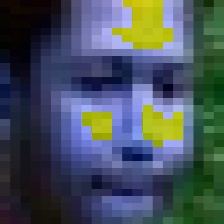

In [29]:
import cv2
from IPython.display import display, clear_output
import time

def play_frames(folder, delay=60):
    frame_paths = sorted([str(p) for p in Path(folder).glob("*.jpg")])
    for fp in frame_paths:
        img = cv2.imread(fp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(img))
        time.sleep(delay/1000)
        clear_output(wait=True)

# Example
play_frames("cropped/20_25__walking_down_street_outside_angry__ZG0SRZOA_fake")


Test ROC Eval: 100%|██████████| 60/60 [01:58<00:00,  1.98s/it]


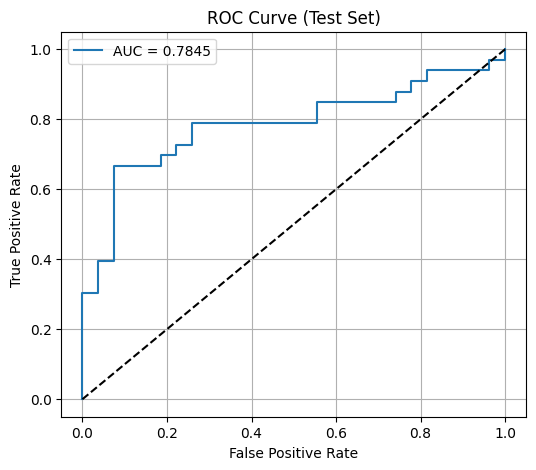

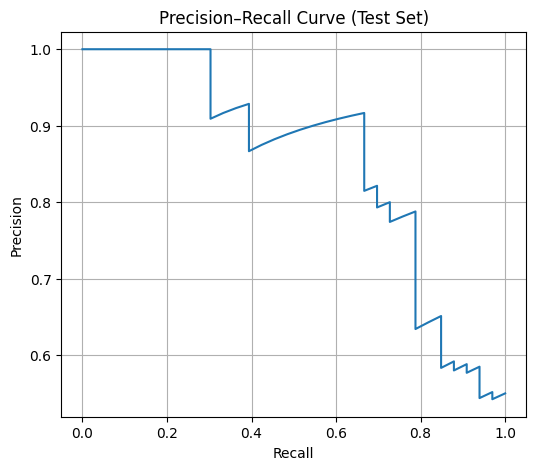


 Test ROC AUC Score: 0.7845


In [22]:
# ============================================
# Cell X: ROC Curve + AUC + Precision–Recall (TEST SET)
# ============================================

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Collect probabilities for ROC & PR analysis
model.eval()
test_labels = []
test_probs  = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Test ROC Eval"):
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(videos)
        probs = torch.sigmoid(logits)

        test_labels.append(labels.item())
        test_probs.append(probs.item())

# Convert to numpy
labels_np = np.array(test_labels)
probs_np  = np.array(test_probs)

# ------------------------ ROC Curve --------------------------
fpr, tpr, _ = roc_curve(labels_np, probs_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------- Precision–Recall Curve -------------------
precision, recall, _ = precision_recall_curve(labels_np, probs_np)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.grid(True)
plt.show()

print(f"\n Test ROC AUC Score: {roc_auc:.4f}")


In [20]:
# ============================================
# Cell X: Proper Test Set Metrics (Accuracy, F1, Precision, Recall)
# ============================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

model.eval()
test_labels = []
test_preds  = []
test_probs  = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Test Metrics Eval"):
        videos = videos.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(videos)
        probs = torch.sigmoid(logits)

        preds = (probs > 0.5).long()

        test_labels.append(labels.item())
        test_preds.append(preds.item())
        test_probs.append(probs.item())

# Convert to numpy arrays
y_true = np.array(test_labels)
y_pred = np.array(test_preds)
y_prob = np.array(test_probs)

# ---- Metrics ----
test_accuracy  = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, zero_division=0)
test_recall    = recall_score(y_true, y_pred, zero_division=0)
test_f1        = f1_score(y_true, y_pred, zero_division=0)


print("\nTEST SET RESULTS")

print(f"Accuracy       : {test_accuracy:.4f}")
print(f"Precision (FAKE class=1): {test_precision:.4f}")
print(f"Recall    (FAKE class=1): {test_recall:.4f}")
print(f"F1 Score  (FAKE class=1): {test_f1:.4f}")




Test Metrics Eval: 100%|██████████| 60/60 [02:03<00:00,  2.07s/it]


TEST SET RESULTS
Accuracy       : 0.7500
Precision (FAKE class=1): 0.8462
Recall    (FAKE class=1): 0.6667
F1 Score  (FAKE class=1): 0.7458


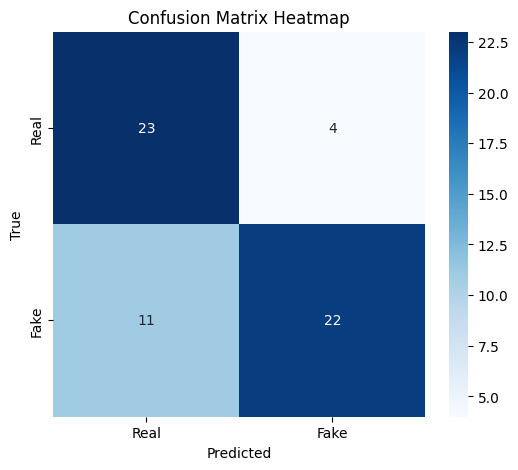

In [21]:
# ============================================
# Confusion Matrix Heatmap
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_np, (probs_np > 0.5).astype(int))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()
